# Introduction
In this small project we will take a look at Seattle weather dataset from Kaggle to extract important features and use them to test functionality of Recurrent Neural Network.
<br><br>
#### Main objective
Build a model using PyTorch library that predicts temperature for the next day.
<br><br>
#### Process includes:
1. **Data** <br>
&ensp;1.1 Overview <br>
&ensp;1.2 Anomalies <br>
&ensp;1.3 Visualization <br>
&ensp;1.4 Preparing data for model <br>
2. **Building model** <br>
&ensp;2.1 Train / test split <br>
&ensp;2.2 Sequencing datasets <br>
&ensp;2.3 Class LSTM <br>
&ensp;2.4 Training function <br>
&ensp;2.5 Testing function <br>
&ensp;2.6 Training and Testing the RNN models <br>
3. **Conclusion**

#### Setup

In [66]:
import matplotlib.pyplot as plt

WHITE_MID = '#b5b5b5'
GREY_DARK = '#141414'

plt.rcParams['figure.facecolor'] = GREY_DARK
plt.rcParams['text.color'] = WHITE_MID
plt.rcParams['axes.facecolor'] = GREY_DARK
plt.rcParams['axes.edgecolor'] = WHITE_MID
plt.rcParams['axes.labelcolor'] = WHITE_MID
plt.rcParams['axes.titlecolor'] = WHITE_MID

plt.rcParams['grid.color'] = WHITE_MID
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.grid'] = True

plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.color'] = WHITE_MID
plt.rcParams['ytick.color'] = WHITE_MID
plt.rcParams['legend.edgecolor'] = WHITE_MID
plt.rcParams['legend.labelcolor'] = WHITE_MID

In [67]:
import numpy as np
import torch
import random
import warnings

warnings.filterwarnings("ignore")

seed = 42

random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# I - Data
#### 1.1 Overview
To preview dataset we're going to use pandas library. <br><br>
Following authors description: <br><br>
**_precipitation_** - all forms in which water falls on the land surface and open water bodies as rain, sleet, snow, hail, or drizzle <br>
**_temp_max_** - highest temperature recorded that day <br>
**_temp_min_** - lowest temperature recorded that day <br>
**_wind_** - wind speed <br>
**_weather_** - weather condition <br>

In [68]:
import pandas as pd

df = pd.read_csv('seattle-weather.csv')
df

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain
...,...,...,...,...,...,...
1456,2015-12-27,8.6,4.4,1.7,2.9,rain
1457,2015-12-28,1.5,5.0,1.7,1.3,rain
1458,2015-12-29,0.0,7.2,0.6,2.6,fog
1459,2015-12-30,0.0,5.6,-1.0,3.4,sun


In [69]:
df['date'] = pd.to_datetime(df['date']) # convert date to actual date format
df.set_index('date', inplace=True) # attach it as index column

In [70]:
df.isna().sum() # search for nulls

precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

In [71]:
df[df.duplicated(keep=False)].sort_values(by=['temp_max', 'wind'], ascending=False) # search for duplicates, sort it first by temp_avg, then by wind

,precipitation,temp_max,temp_min,wind,weather
date,,,,,
2014-07-14,0.0,27.8,15.0,2.8,sun
2014-08-17,0.0,27.8,15.0,2.8,sun
2012-05-14,0.0,26.7,12.8,3.8,sun
2012-07-07,0.0,26.7,12.8,3.8,sun
2014-05-13,0.0,26.7,12.8,3.8,sun
2012-08-29,0.0,22.8,13.3,2.4,sun
2015-09-08,0.0,22.8,13.3,2.4,sun
2013-09-18,0.0,21.1,13.3,2.5,sun
2013-09-21,0.0,21.1,13.3,2.5,sun


In [72]:
if bool(len(df[df['temp_min'] >= df['temp_max']])): # temp_min >= temp_max
    df[df.temp_min >= df.temp_max]
elif len(df[(df.wind < 0) | (df.precipitation < 0)]): # negative values in wind and precipitation columns
    df[(df.wind < 0) | (df.precipitation < 0)]
else:
    pass

"rainy" weather but no actual rain.

In [73]:
df_rainy = df['weather'] == 'rain'
df_noprecip = df['precipitation'] == 0
print(len(df[(df_rainy) & (df_noprecip)]))
df[(df_rainy) & (df_noprecip)].head()

44


,precipitation,temp_max,temp_min,wind,weather
date,,,,,
2012-01-07,0.0,7.2,2.8,2.3,rain
2012-01-23,0.0,8.3,1.1,3.6,rain
2012-01-28,0.0,6.7,0.6,2.2,rain
2012-02-25,0.0,7.2,2.8,6.4,rain
2012-03-04,0.0,10.6,6.7,5.6,rain


It's sketchy, but I guess the weather 'rain' doesn't mean we have to expect rain that day but the 'feeling' of the weather.

#### 1.3 Visualization
Using different type of plots from seaborn to find correlations and patterns.

In [74]:
df.describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


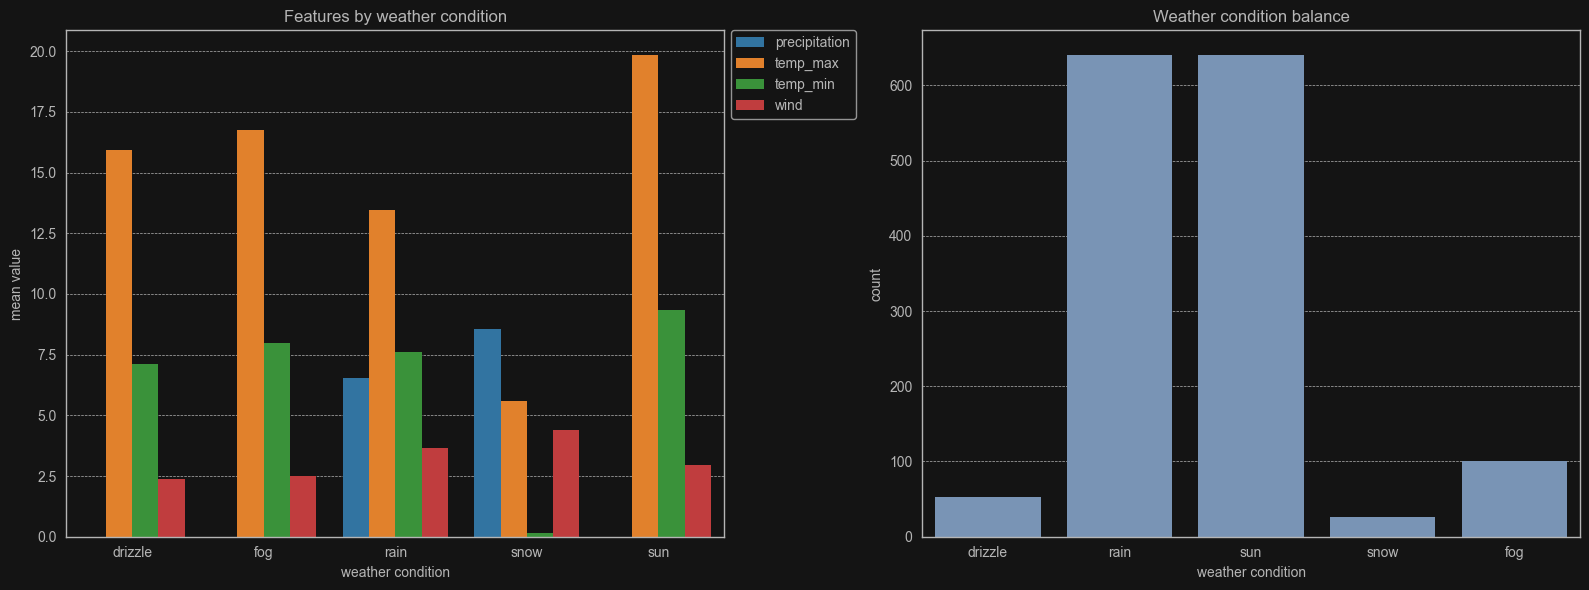

In [75]:
import seaborn as sb

mid_blue = '#6f93bf'
mid_red = '#bf6f6f'

mean_per_weather = df.groupby('weather').mean(numeric_only=True).reset_index()
melted = mean_per_weather.melt(id_vars='weather')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
axes = axes.flatten()

sb.barplot(data=melted, x='weather', y='value', hue='variable', linewidth=0, ax=axes[0])
axes[0].set_title('Features by weather condition')
axes[0].set_ylabel('mean value')
axes[0].set_xlabel('weather condition')
axes[0].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

sb.countplot(data=df, x='weather', color=mid_blue, edgecolor='none', ax=axes[1])
axes[1].set_title('Weather condition balance')
axes[1].set_xlabel('weather condition')

plt.tight_layout()

Text(0.5, 1.0, 'Correlation')

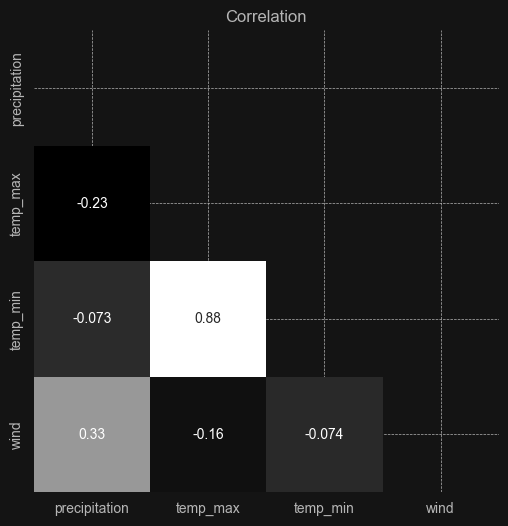

In [76]:
df = df.drop(['weather'], axis=1) # drop weather column

fig = plt.figure(figsize=(6, 6))
sb.heatmap(df.corr(), annot=True, cmap='Greys_r', cbar=False, mask=np.triu(np.ones(len(df.corr())), k=0))
plt.title('Correlation')

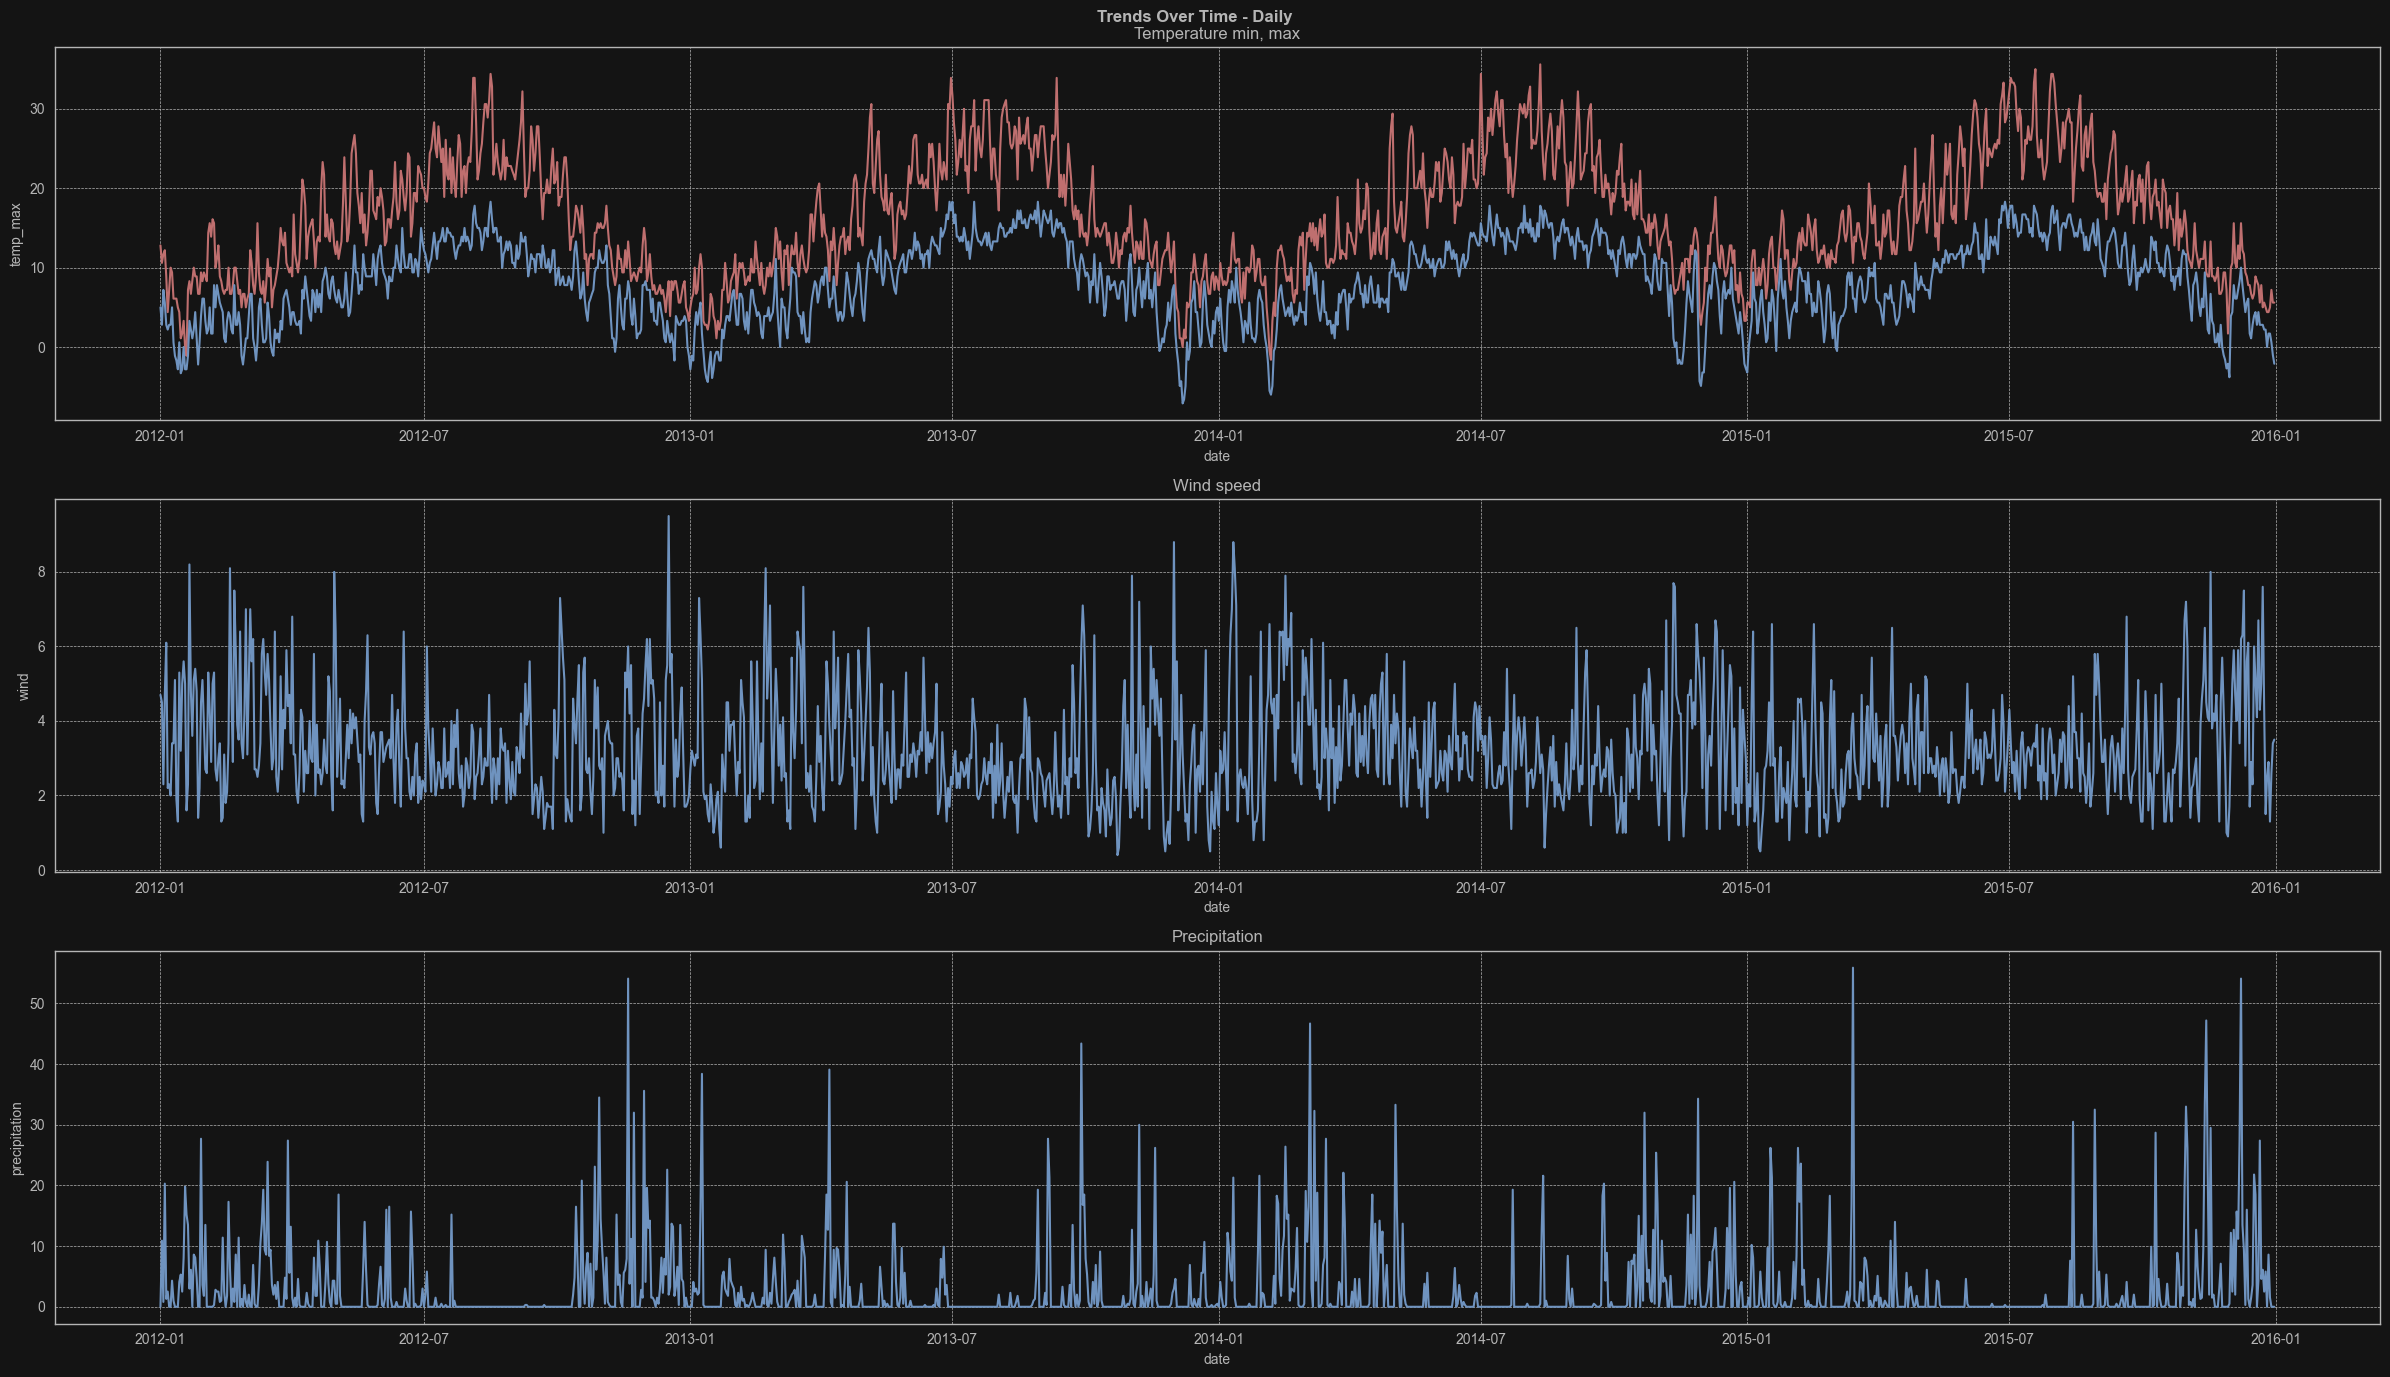

In [77]:
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(24, 14))
axes = axes.flatten()

sb.lineplot(data=df, x='date', y='temp_max', color=mid_red, ax=axes[0])
sb.lineplot(data=df, x='date', y='temp_min', color=mid_blue, ax=axes[0])
sb.lineplot(data=df, x='date', y='wind', color=mid_blue, ax=axes[1])
sb.lineplot(data=df, x='date', y='precipitation', color=mid_blue, ax=axes[2])

axes[0].set_title('Temperature min, max')
axes[1].set_title('Wind speed')
axes[2].set_title('Precipitation')

fig.suptitle('Trends Over Time - Daily', fontweight='bold')
plt.tight_layout()

Seasonal pattern suggests that more precipitations appear in autumn months.<br>
During winter season wind speed varies notably more comparing to summer season.<br><br>
Since both temp_min and temp_max change almost the same way, we can extract _**average temperature**_. <br>
This can reduce the number of values for the model to calculate and change the input size by removing redundant features.

In [78]:
temp_avg = df[['temp_max', 'temp_min']].mean(axis=1) # calculate mean
df.drop(['temp_max', 'temp_min'], axis=1, inplace=True)
df.insert(2, 'temp_avg', temp_avg)
df.head()

,precipitation,wind,temp_avg
date,,,
2012-01-01,0.0,4.7,8.90
2012-01-02,10.9,4.5,6.70
2012-01-03,0.8,2.3,9.45
2012-01-04,20.3,4.7,8.90
2012-01-05,1.3,6.1,5.85


In [79]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features = ['precipitation', 'temp_avg', 'wind']

df.loc[:, features] = scaler.fit_transform(df[features]) # applying scaled features to numeric features

df.describe()

,precipitation,wind,temp_avg
count,1461.000000,1461.000000,1461.000000
mean,0.054194,0.312213,0.529080
std,0.119503,0.158003,0.196657
min,0.000000,0.000000,0.000000
25%,0.000000,0.197802,0.378689
50%,0.000000,0.285714,0.516393
75%,0.050089,0.395604,0.688525
max,1.000000,1.000000,1.000000


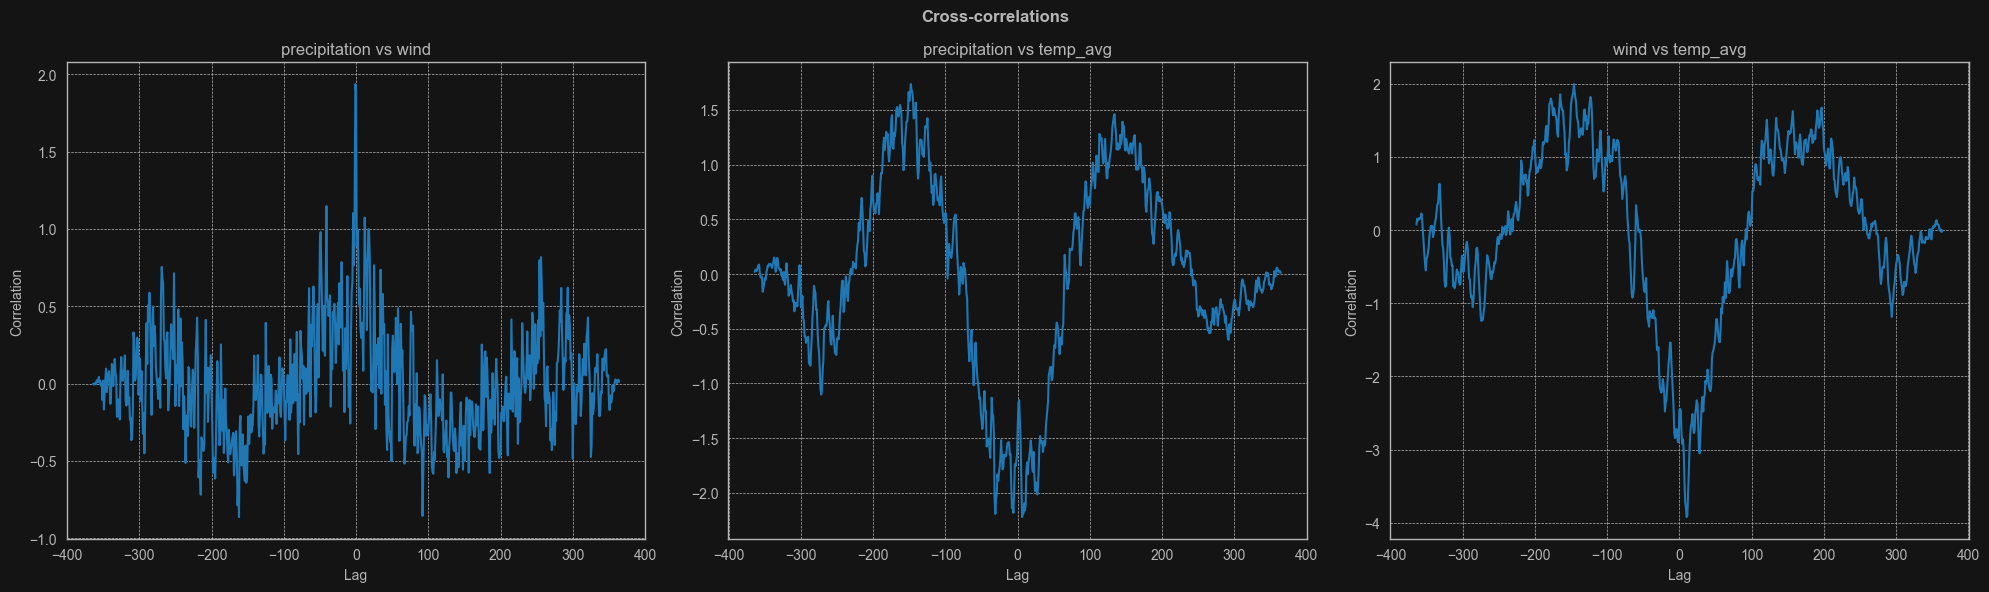

In [86]:
from scipy.signal import correlate
from itertools import combinations

year_i = 2
year_i *= 365
df_sample = df[year_i:year_i+365]

numeric_features = df.select_dtypes(include='number').columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
axes = axes.flatten()

for i, comb in enumerate(combinations(numeric_features, r=2)):
    feat_a, feat_b = comb
    
    x = df_sample[feat_a] - np.mean(df_sample[feat_a]) # center feature a
    y = df_sample[feat_b] - np.mean(df_sample[feat_b]) # center feature b
    
    correlation = correlate(x, y, mode='full') # cross correlation
    lags = np.arange(-len(x) + 1, len(x))
    
    axes[i].plot(lags, correlation)
    axes[i].set_title(f'{feat_a} vs {feat_b}')
    axes[i].set_xlabel('Lag')
    axes[i].set_ylabel('Correlation')

plt.suptitle('Cross-correlations', fontweight='bold')
plt.tight_layout()

#### 1.4 Granger causality
We check if one certain feature helps to predict average temperature. For this we can use Granger causality test. <br>
Technically it's more useful for linear models. I want to check if it actually gives any clues while choosing features for LSTM. <br>
This indicates how X helps to predict Y. <br>

In [109]:
from statsmodels.tsa.stattools import grangercausalitytests as granger
from statsmodels.tsa.stattools import adfuller

features = ['wind', 'temp_avg', 'precipitation']

for feat in features:
    result = adfuller(df[feat])

    output = {
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Used lags': result[2],
        'N obs': result[3],
        'Critical Values': result[4],
        'IC best (AIC)': result[5]
    }

    print(feat.upper())
    for k, v in output.items():
        print(f"{k:>20}: ", v)
    print('\n')

WIND
       ADF Statistic:  -24.507371901200795
             p-value:  0.0
           Used lags:  0
               N obs:  1460
     Critical Values:  {'1%': np.float64(-3.434836872962171), '5%': np.float64(-2.863521656701378), '10%': np.float64(-2.567825016419591)}
       IC best (AIC):  -1519.7441280138842


TEMP_AVG
       ADF Statistic:  -2.306794965693254
             p-value:  0.16978582450829816
           Used lags:  13
               N obs:  1447
     Critical Values:  {'1%': np.float64(-3.4348772553489617), '5%': np.float64(-2.8635394783531085), '10%': np.float64(-2.5678345067434516)}
       IC best (AIC):  -4017.852935099587


PRECIPITATION
       ADF Statistic:  -16.797530555019144
             p-value:  1.227797220047623e-29
           Used lags:  2
               N obs:  1458
     Critical Values:  {'1%': np.float64(-3.434843038681996), '5%': np.float64(-2.8635243777871286), '10%': np.float64(-2.56782646544019)}
       IC best (AIC):  -2183.184385796953




p-value for _temp_avg_ indicates that the time series for this feature is not stationary. <br>
However we can differentiate the series of data to achieve stationary version of said series.

In [113]:
temp_avg_diff = df.temp_avg.diff().dropna()
result = adfuller(temp_avg_diff)

output = pd.DataFrame.from_dict({
    'ADF Statistic': result[0],
    'p-value': result[1],
    'Used lags': result[2],
    'N obs': result[3],
    'Critical Values': result[4],
    'IC best (AIC)': result[5]
})

output

,ADF Statistic,p-value,Used lags,N obs,Critical Values,IC best (AIC)
1%,-15.684912,1.457422e-28,12,1447,-3.434877,-4010.992457
5%,-15.684912,1.457422e-28,12,1447,-2.863539,-4010.992457
10%,-15.684912,1.457422e-28,12,1447,-2.567835,-4010.992457


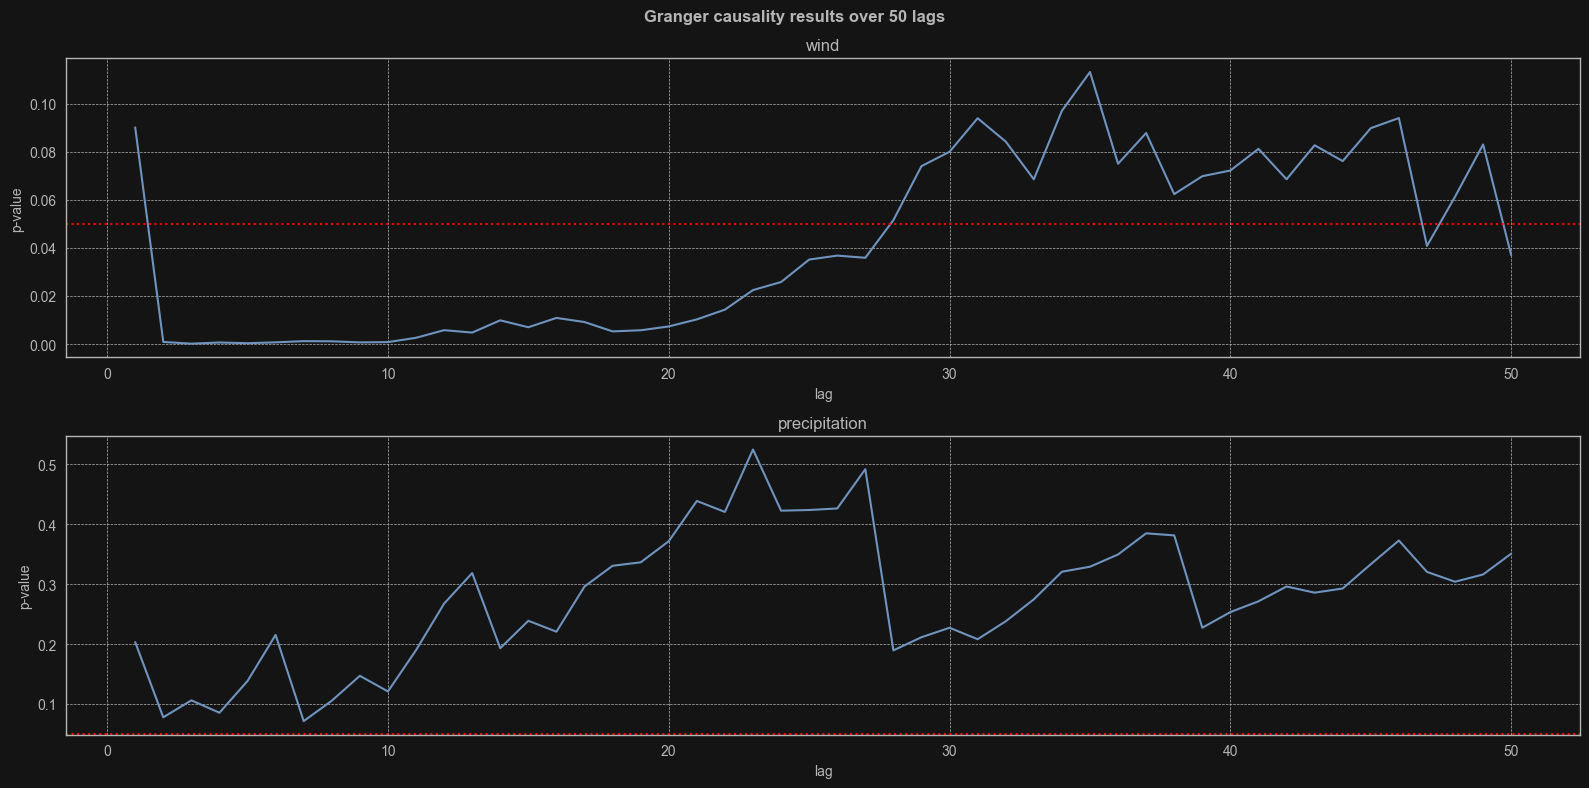

In [115]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))
axes = axes.flatten()

n_lags = 50

for i, feature in enumerate(['wind', 'precipitation']):
    
    # shift the series from original dataframe because diff returns NAN value for first row
    wind_cut = df[feature].loc[temp_avg_diff.index]
    
    # create temporary dataframe for granger test
    granger_df = pd.DataFrame.from_dict({
        feature: wind_cut,
        'temp_avg': temp_avg_diff
    })

    # define granger test
    granger_wind_temp = granger(x=granger_df[[feature, 'temp_avg']], maxlag=n_lags, verbose=False)
    
    # get p_values from granger test
    p_values = [round(granger_wind_temp[lag+1][0]['ssr_ftest'][1], n_lags) for lag in range(n_lags)]
    p_values
    
    # plot
    sb.lineplot(x=[x for x in range(1, n_lags+1)], y=p_values, color=mid_blue, ax=axes[i])
    axes[i].set_title(feature)
    axes[i].set_ylabel('p-value')
    axes[i].set_xlabel('lag')
    axes[i].axhline(y=0.05, color='red', ls=':')
    
plt.suptitle(f'Granger causality results over {n_lags} lags', fontweight='bold')
plt.tight_layout()

# II - Building model
#### 2.1 Train / test split
Splitting dataset using week stamps.

In [123]:
train_size = int(len(df) * 0.7) + 1
test_size = int(len(df) * 0.3)

print(
    f"{f"train size":>12}: {train_size}",
    f"{f"test size":>12}: {test_size}",
    len(df) == train_size + test_size,
    sep='\n'
)

  train size: 1023
   test size: 438
True


In [124]:
df_train = df[:train_size]
df_test = df[train_size:]

We're going to pass sequenced data with length of 7 days per sequence. <br>
Knowing that, we have to make sure that our datasets are divisible by 7. <br>

In [125]:
df_train = df_train[:(len(df_train) // 7) * 7]
df_test = df_test[:(len(df_test) // 7) * 7]

In [127]:
print(
    len(df_train),
    len(df_test), sep='\n'
)

1022
434


Convert each data split to numpy, so we're able to pass it to torch.

In [128]:
df_train_torch = df_train.to_numpy()
df_train_torch = torch.tensor(df_train_torch)

df_test_torch = df_test.to_numpy()
df_test_torch = torch.tensor(df_test_torch)
df_test_torch[:7]

tensor([[0.2093, 0.2967, 0.5885],
        [0.0179, 0.4725, 0.5803],
        [0.5725, 0.5055, 0.5721],
        [0.1682, 0.4615, 0.4967],
        [0.0733, 0.3077, 0.5066],
        [0.1091, 0.5495, 0.5344],
        [0.0268, 0.5055, 0.4623]], dtype=torch.float64)

#### 2.2 - Sequencing datasets
To predict weather conditions based on features from past 6 days, <br>
we have to reshape our data split sets to return specific sequences. <br><br>
Each sequence containing data from 7 days, where: <br>
X - precipitation, temp_avg and wind speed features from first 6 days <br>
y - same features, but we take just day 7th

In [185]:
from torch.utils.data import TensorDataset, DataLoader

def sequence_dataset(dataset, batch_size):
    
    x, y = [], []
    
    for i in range(0, len(dataset) - 7):
        
        week = dataset[i: i + 7, :] # take everything except 'weather'
        week_features = week[:7-1, -1] # trim to 6 days
        week_target = week[-1, -1] # take last day
        
        x.append(week_features)
        y.append(week_target)
        
    # covert to tensor dataset
    tensor_dataset = TensorDataset(torch.tensor(np.asarray(x)),
                                   torch.tensor(np.asarray(y)))
    
    # covert to data_loader
    data_loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    return data_loader

In [130]:
batch_size = 8
train_loader = sequence_dataset(df_train_torch, batch_size=batch_size)
test_loader = sequence_dataset(df_test_torch, batch_size=batch_size)

In [133]:
i = 2

for batch in test_loader:
    input, target = batch
    print(input, target)
    print(input.size())
    print(target.size())
    break

tensor([[0.2344, 0.3525, 0.4787, 0.4246, 0.3443, 0.2803],
        [0.3705, 0.4066, 0.3885, 0.4967, 0.3787, 0.3066],
        [0.6443, 0.6902, 0.7721, 0.8246, 0.8902, 0.8623],
        [0.5246, 0.4885, 0.4426, 0.4066, 0.3787, 0.2787],
        [0.2984, 0.2443, 0.3508, 0.2803, 0.2344, 0.1443],
        [0.3426, 0.4443, 0.5164, 0.4787, 0.4344, 0.3705],
        [0.4246, 0.3525, 0.3623, 0.4344, 0.4246, 0.3705],
        [0.2525, 0.2082, 0.2344, 0.2443, 0.2639, 0.2344]], dtype=torch.float64) tensor([0.3426, 0.2984, 0.8344, 0.2967, 0.1344, 0.3705, 0.3885, 0.3426],
       dtype=torch.float64)
torch.Size([8, 6])
torch.Size([8])


The shape corresponds to: <br>
&emsp;4 - batch size <br>
&emsp;6 - n days in sequence <br>
&emsp;3 - n features for single day <br><br>
Note that before I've said that sequence is 7 days but our input is now 6 days. That's because the 7th day became y/label.

In [134]:
for batch in train_loader:
    input, target = batch
    print(input[0], target[0], sep='\n')
    break

tensor([0.5705, 0.5705, 0.6426, 0.7164, 0.6262, 0.5705], dtype=torch.float64)
tensor(0.6066, dtype=torch.float64)


#### 2.3 class LSTM
With PyTorch we are able to build simple RNN with Long Short-Term Memory layers by simply attaching _nn.LSTM()_ with specific factors in it. <br>
The __init__ function first initializes the LSTM and fully connected layers. <br>
__*forward()*__ passes our input x to the rnn network then fully connects it to finally return last value from the output.

In [135]:
from torch import nn

class WeatherRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=3, n_layers=2, dropout=0):
        super(WeatherRNN, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=n_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :]) # take the last hidden
        return out

#### 2.4 Training function
So we take our train_loader and pass it to our training function. <br>
Training function iterates over batches for n_epoch times and passes sequences from these batches to our model <br>
that calculates loss by comparing calculated outputs with actual targets using Mean Squared Error function.

In [192]:
import torch.optim as optim

def train_model(model, device, train_loader, n_epochs=1, lr=0.001):
    
    model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        
        for i, batch in enumerate(train_loader):
            inputs, targets = batch
            inputs, targets = (inputs.to(device).float(),
                               targets.to(device).float())

            inputs = inputs.unsqueeze(-1)
            
            optimizer.zero_grad() # clean gradients
            outputs = model(inputs) # calculate outputs
            
            loss = criterion(outputs, targets.unsqueeze(1)) # add dim
            loss.backward() # backpropagation
            optimizer.step() # update weights
            
            total_loss += loss.item()
            
        print(f"Epoch {epoch + 1} / {n_epochs} finished | {total_loss/len(train_loader):.4f}")

#### 2.5 Testing function
Similar to training function. This time we run the model with no gradients calculations <br>
and iterate through batches from test_loader. <br>
Then return y true and y predicted values to compare where the model makes most mistakes.

In [197]:
def test_model(model, device, test_loader):
    total_loss = 0
    criterion = nn.MSELoss()
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            inputs, targets = (inputs.to(device).float(),
                               targets.to(device).float())
            
            inputs = inputs.unsqueeze(-1)

            outputs = model(inputs) # get outputs

            loss = criterion(outputs, targets.unsqueeze(1)) # add dim
            total_loss += loss.item()

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    print(f"Test MSE Loss: {avg_loss:.4f}")

    return y_true, y_pred


#### 2.6 Training and Testing the RNN models

In [194]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 1
output_size = 1
hidden_size = 128
n_layers = 1
dropout = 0
learning_rate = 0.0005

n_epochs = 30

weather_rnn = WeatherRNN(input_size=input_size, hidden_size=hidden_size, n_layers=n_layers, output_size=output_size, dropout=dropout)

In [195]:
train_model(weather_rnn, device=device, train_loader=train_loader, n_epochs=n_epochs, lr=learning_rate)

Epoch 1 / 30 finished | 0.0513
Epoch 2 / 30 finished | 0.0086
Epoch 3 / 30 finished | 0.0081
Epoch 4 / 30 finished | 0.0081
Epoch 5 / 30 finished | 0.0075
Epoch 6 / 30 finished | 0.0073
Epoch 7 / 30 finished | 0.0070
Epoch 8 / 30 finished | 0.0071
Epoch 9 / 30 finished | 0.0071
Epoch 10 / 30 finished | 0.0070
Epoch 11 / 30 finished | 0.0064
Epoch 12 / 30 finished | 0.0062
Epoch 13 / 30 finished | 0.0061
Epoch 14 / 30 finished | 0.0056
Epoch 15 / 30 finished | 0.0057
Epoch 16 / 30 finished | 0.0053
Epoch 17 / 30 finished | 0.0052
Epoch 18 / 30 finished | 0.0048
Epoch 19 / 30 finished | 0.0046
Epoch 20 / 30 finished | 0.0045
Epoch 21 / 30 finished | 0.0042
Epoch 22 / 30 finished | 0.0040
Epoch 23 / 30 finished | 0.0040
Epoch 24 / 30 finished | 0.0038
Epoch 25 / 30 finished | 0.0038
Epoch 26 / 30 finished | 0.0038
Epoch 27 / 30 finished | 0.0037
Epoch 28 / 30 finished | 0.0039
Epoch 29 / 30 finished | 0.0038
Epoch 30 / 30 finished | 0.0036


In [198]:
y_true, y_pred = test_model(weather_rnn, device=device, test_loader=test_loader)

Test MSE Loss: 0.0041


In [241]:
temp_avg_true = np.array(y_true).flatten()
temp_avg_pred = np.array(y_pred).flatten()

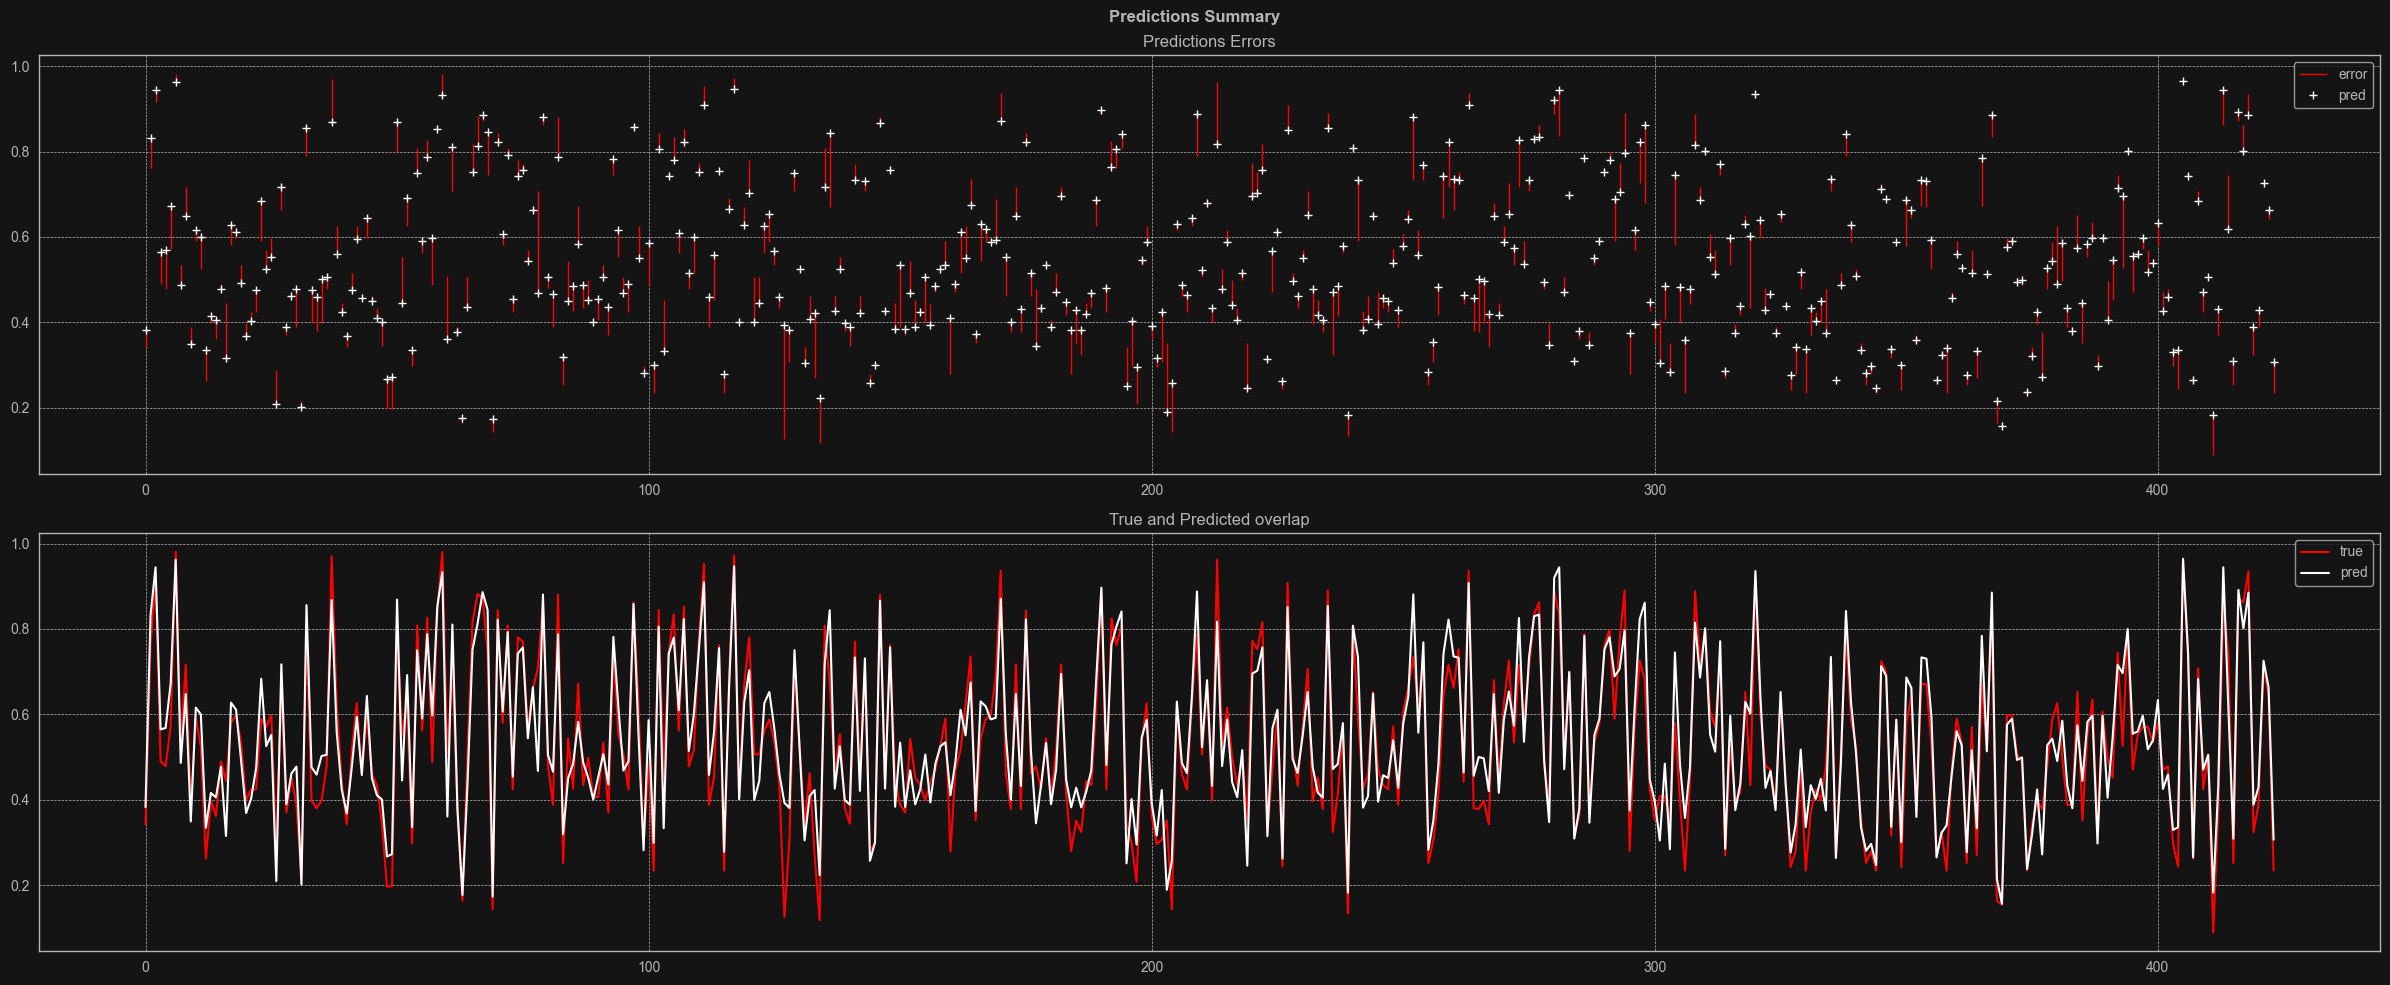

In [242]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(24, 10))
axes = axes.flatten()

x = range(len(temp_avg_true))
axes[0].vlines(x=x, ymin=temp_avg_pred, ymax=temp_avg_true, color='red', linewidth=1, label='error')
axes[0].plot(x, y_pred, marker='+', linestyle='None', color='white', label='pred')

sb.lineplot(x=range(len(temp_avg_true)), y=temp_avg_true, color='red', ax=axes[1], label='true')
sb.lineplot(x=range(len(temp_avg_pred)), y=temp_avg_pred, color='white', ax=axes[1], label='pred')

axes[0].set_title('Predictions Errors')
axes[0].legend()

axes[1].set_title('True and Predicted overlap')

plt.suptitle('Predictions Summary', fontweight='bold')
plt.tight_layout()

In [244]:
from scipy.stats import hmean

true_deg = np.zeros((len(temp_avg_true), input_size))
pred_deg = np.zeros((len(temp_avg_pred), input_size))

true_deg = np.sqrt(temp_avg_true).reshape(-1, 1)
pred_deg = np.sqrt(temp_avg_pred).reshape(-1, 1)

true_deg = scaler.inverse_transform(true_deg)
pred_deg = scaler.inverse_transform(pred_deg)

diff = abs(true_deg - pred_deg)

print(
    f"{"mean":>6}: {diff.mean()}",
    f"{"hmean":>6}: {hmean(diff)}",
    f"{"max":>6}: {diff.max()}",
    f"{"min":>6}: {diff.min()}",
    f"{"min":>6}: {true_deg.max() - true_deg.min()}",
    sep='\n'
)

ValueError: non-broadcastable output operand with shape (424,1) doesn't match the broadcast shape (424,3)

In [ ]:
diff

In [ ]:
precip_true = np.array(y_true)[:, 0]
precip_pred = np.array(y_pred)[:, 0]

temp_avg_true = np.array(y_true)[:, 1]
temp_avg_pred = np.array(y_pred)[:, 1]

wind_true = np.array(y_true)[:, 2]
wind_pred = np.array(y_pred)[:, 2]

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(24, 10))
axes = axes.flatten()

sb.lineplot(x=range(len(precip_true)), y=precip_true, color='red', ax=axes[0], label='True')
sb.lineplot(x=range(len(precip_pred)), y=precip_pred, color='white', ax=axes[0], label='Pred')
axes[0].set_title('precipitation')

sb.lineplot(x=range(len(temp_avg_true)), y=temp_avg_true, color='red', ax=axes[1], label='True')
sb.lineplot(x=range(len(temp_avg_pred)), y=temp_avg_pred, color='white', ax=axes[1], label='Pred')
axes[1].set_title('average temperature')

sb.lineplot(x=range(len(wind_true)), y=wind_true, color='red', ax=axes[2], label='True')
sb.lineplot(x=range(len(wind_pred)), y=wind_pred, color='white', ax=axes[2], label='Pred')
axes[2].set_title('wind speed')

plt.suptitle('Predictions', fontweight='bold')
plt.tight_layout()

# III - Conclusion
Clearly the model doesn't understand the chaos that is in the _precipitation_ and _wind_ columns. <br>
I suppose predicting such thing as weather with both high precision <br>
and large amount of features requires more than just 3 numeric columns. <br>
Despite this fact the model did decent job with predicting average temperature and recognizing patterns inside. <br><br>
Overall I think this project gives quiet simple fundamentals to understand the functionality of Recurrent Neural Networks.
#### Thanks for reading my project, I hope you enjoyed the process :]
_Gracjan Pawłowski 2025_